In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os

In [6]:
PLATE_SEPARATION = 45 # mm

In [7]:
tests = {}
heights = {}
moduli = {}
for file in Path('.').rglob('*.csv'):
    # load
    df = pd.read_csv(file, skiprows=5)
    df.columns = df.columns.map(str) + ' ' + df.iloc[0]
    df.drop(df.index[0], inplace=True)
    df = df.astype(float)
    
    # find index of first compressive strain that is > 1.5% to adjust for slack in test specimen
    # the limit is arbitrary based on pre-analyzing and plotting the raw stress/strain data
    adjust_strain_limit = 2.
    idx = df.index[df['Compressive strain (Displacement) (%)'] > adjust_strain_limit].tolist()[0]
    # adjust all columns to be zeroed at this index
    for col in df.columns:
        df[col] = df[col] - df[col][idx]
        
        
    # linear fit using strain up to 2% (arbitrary limit) using numpy
    strain_bounds = (0., 1)
    mask = (df['Compressive strain (Displacement) (%)'] >= strain_bounds[0]) & (df['Compressive strain (Displacement) (%)'] <= strain_bounds[1])
    coeffs = np.polyfit(df['Compressive strain (Displacement) (%)'][mask], df['Compressive stress (kPa)'][mask], 1)
    print(coeffs)
    df['Linear stress fit'] = np.polyval(coeffs, df['Compressive strain (Displacement) (%)'])


    tests[file.stem] = df

[ 0.53811698 -0.00120871]
[ 0.54600515 -0.00240969]
[ 0.50573062 -0.00332707]
[21.74578599 -0.28201392]
[ 0.55850711 -0.0025737 ]
[22.19824205 -0.32073922]
[21.12218368 -0.42029725]


(0.00036485118082671923, 100.0)

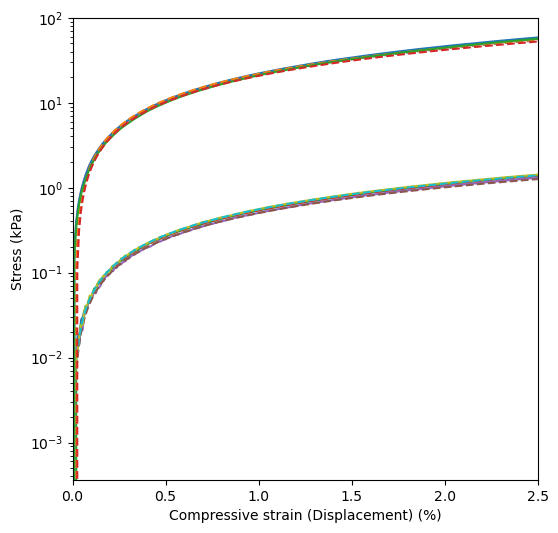

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
for test, data in tests.items():
    # ax.plot(data['Compressive strain (Displacement) (%)'], data['Compressive stress (kPa)'], label=test)
    data.plot(x='Compressive strain (Displacement) (%)', y='Compressive stress (kPa)', ax=ax, legend=False)
    data.plot(x='Compressive strain (Displacement) (%)', y='Linear stress fit', ax=ax, style='--', legend=False)

ax.set_ylabel('Stress (kPa)')
ax.set_yscale('log')
ax.set_xlim(0, 2.5)
ax.set_ylim(None, 1e2)
